# A study of Regression applied on Ames Dataset

Link to the notebook

https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

In [2]:
df = pd.read_csv('train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.000,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.000,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.000,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.000,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
df.shape

(1460, 81)

In [4]:
#Dropping duplicate Ids if any
idsUnique = len(set(df.Id))
idsTotal = df.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

# Drop Id column
df.drop("Id", axis = 1, inplace = True)

There are 0 duplicate IDs for 1460 total entries


# Preprocessing

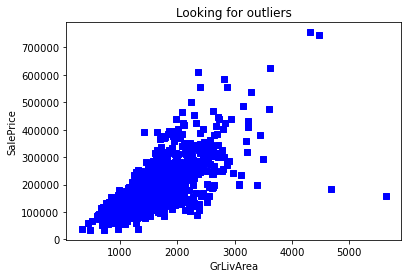

In [5]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(df.GrLivArea, df.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

df = df[df.GrLivArea < 4000]

In [6]:
df.shape  # we can confirm 4 entries were removed and we also removed Id column

(1456, 80)

In [7]:
df.SalePrice.describe()

count     1456.000
mean    180151.234
std      76696.593
min      34900.000
25%     129900.000
50%     163000.000
75%     214000.000
max     625000.000
Name: SalePrice, dtype: float64

In [8]:
# Log transform the target for official scoring
# Log tranform will help predicting expensive and cheap house with the same error
# Log1p calculates log(1+x)
df.SalePrice = np.log1p(df.SalePrice)
y = df.SalePrice
y.describe()

D:\Anaconda\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


count   1456.000
mean      12.022
std        0.396
min       10.460
25%       11.775
50%       12.002
75%       12.274
max       13.346
Name: SalePrice, dtype: float64

# Dealing with Missing values 

In [9]:
(df.isnull().sum()).sort_values(ascending=False).head(20)

PoolQC          1451
MiscFeature     1402
Alley           1365
Fence           1176
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageCond        81
GarageFinish      81
GarageQual        81
GarageYrBlt       81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
RoofMatl           0
dtype: int64

In [10]:
# Handle missing values for features where median/mean or most common value doesn't make sense

# Data Description says NaN signifies No alley access
df.loc[:,'Alley'] = df.loc[:,'Alley'].fillna('None')

# NaN probably says no lot frontage
df.loc[:,'LotFrontage'] = df.loc[:,'LotFrontage'].fillna(0)

# NaN means No pool
df.loc[:,'PoolQC'] = df.loc[:,'PoolQC'].fillna('No')

# Nan means no misc feature
df.loc[:,'MiscFeature'] = df.loc[:,'MiscFeature'].fillna('No')

# Nan means no fence
df.loc[:,'Fence'] = df.loc[:,'Fence'].fillna('No')

# NaN means no fireplace
df.loc[:,'FireplaceQu'] = df.loc[:,'FireplaceQu'].fillna('No')

# Nan means no garage
df.loc[:,'GarageType'] = df.loc[:,'GarageType'].fillna('No')

# Nan means no garage
df.loc[:,'GarageCond'] = df.loc[:,'GarageCond'].fillna('No')

# Nan means no garage
df.loc[:,'GarageFinish'] = df.loc[:,'GarageFinish'].fillna('No')

# Nan means no garage
df.loc[:,'GarageQual'] = df.loc[:,'GarageQual'].fillna('No')

# Nan with the median value since filling 0 wont make any sense during visualization
df.loc[:,'GarageYrBlt'] = df.loc[:,'GarageYrBlt'].fillna(1980)

# Nan means no basement
df.loc[:,'BsmtFinType2'] = df.loc[:,'BsmtFinType2'].fillna('No')

# Nan means no basement means no exposure
df.loc[:,'BsmtExposure'] = df.loc[:,'BsmtExposure'].fillna('No')

# Nan means no basement
df.loc[:,'BsmtQual'] = df.loc[:,'BsmtQual'].fillna('No')

# Nan means no basement
df.loc[:,'BsmtCond'] = df.loc[:,'BsmtCond'].fillna('No')

# Nan means no basement
df.loc[:,'BsmtFinType1'] = df.loc[:,'BsmtFinType1'].fillna('No')

# Nan means no garage
df.loc[:,'MasVnrArea'] = df.loc[:,'MasVnrArea'].fillna(0)

# Nan means no garage
df.loc[:,'MasVnrType'] = df.loc[:,'MasVnrType'].fillna('None')

# replacing Nan with most prevalent electrical system
df.loc[:,'Electrical'] = df.loc[:,'Electrical'].fillna('SBrKr')

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [11]:
(df.isnull().sum()).sum()  # NO more missing data

0

In [12]:
# converting some numerical features into categories

df = df.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [13]:
# Encode some categorical features as ordered numbers when there is information in the order
df = df.replace({"Alley" : {"None" : 0, "Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [14]:
df.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,SC60,RL,65.000,8450,2,0,4,Lvl,4,Inside,...,0,0,No,No,0,Feb,2008,WD,Normal,12.248
1,SC20,RL,80.000,9600,2,0,4,Lvl,4,FR2,...,0,0,No,No,0,May,2007,WD,Normal,12.109
2,SC60,RL,68.000,11250,2,0,3,Lvl,4,Inside,...,0,0,No,No,0,Sep,2008,WD,Normal,12.317
3,SC70,RL,60.000,9550,2,0,3,Lvl,4,Corner,...,0,0,No,No,0,Feb,2006,WD,Abnorml,11.849
4,SC60,RL,84.000,14260,2,0,3,Lvl,4,FR2,...,0,0,No,No,0,Dec,2008,WD,Normal,12.429
5,SC50,RL,85.000,14115,2,0,3,Lvl,4,Inside,...,0,0,MnPrv,Shed,700,Oct,2009,WD,Normal,11.871
6,SC20,RL,75.000,10084,2,0,4,Lvl,4,Inside,...,0,0,No,No,0,Aug,2007,WD,Normal,12.635
7,SC60,RL,0.000,10382,2,0,3,Lvl,4,Corner,...,0,0,No,Shed,350,Nov,2009,WD,Normal,12.206
8,SC50,RM,51.000,6120,2,0,4,Lvl,4,Inside,...,0,0,No,No,0,Apr,2008,WD,Abnorml,11.775
9,SC190,RL,50.000,7420,2,0,4,Lvl,4,Corner,...,0,0,No,No,0,Jan,2008,WD,Normal,11.678


In [15]:
df.ExterQual.unique()

array([4, 3, 5, 2], dtype=int64)

In [16]:
df.shape

(1456, 80)

# Simplification of existing features and Creation of new ones

In [17]:
# Create new features
# 1* Simplifications of existing features


df["SimplOverallQual"] = df.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
df["SimplOverallCond"] = df.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
df["SimplPoolQC"] = df.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
df["SimplGarageCond"] = df.GarageCond.replace({0 : 1, 1 : 1, # bad
                                                     2 : 2, 3 : 2, # average
                                                     4 : 3, 5 : 3 # good
                                                    })
df["SimplGarageQual"] = df.GarageQual.replace({0 : 0, 1 : 1, # bad
                                                     2 : 2, 3 : 2, # average
                                                     4 : 3, 5 : 3 # good
                                                    })
df["SimplFireplaceQu"] = df.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
df["SimplFireplaceQu"] = df.FireplaceQu.replace({0 : 1, 1 : 1, # bad
                                                       2 : 2, 3 : 2, # average
                                                       4 : 3, 5 : 3 # good
                                                      })
df["SimplFunctional"] = df.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
df["SimplKitchenQual"] = df.KitchenQual.replace({1 : 1, # bad
                                                       2 : 2, 3 : 2, # average
                                                       4 : 3, 5 : 3 # good
                                                      })
df["SimplHeatingQC"] = df.HeatingQC.replace({1 : 1, # bad
                                                   2 : 2, 3 : 2, # average
                                                   4 : 3, 5 : 3 # good
                                                  })
df["SimplBsmtFinType1"] = df.BsmtFinType1.replace({0 :1, 1 : 1, # unfinished
                                                         2 : 2, 3 : 2, # rec room
                                                         4 : 3, 5 : 3, 6 : 3 # living quarters
                                                        })
df["SimplBsmtFinType2"] = df.BsmtFinType2.replace({0 :1, 1 : 1, # unfinished
                                                         2 : 2, 3 : 2, # rec room
                                                         4 : 3, 5 : 3, 6 : 3 # living quarters
                                                        })
df["SimplBsmtCond"] = df.BsmtCond.replace({0 : 1, 1 : 1, # bad
                                                 2 : 2, 3 : 2, # average
                                                 4 : 3, 5 : 3 # good
                                                })
df["SimplBsmtQual"] = df.BsmtQual.replace({0 : 1, 1 : 1, # bad
                                                 2 : 2, 3 : 2, # average
                                                 4 : 3, 5 : 3 # good
                                                })
df["SimplExterCond"] = df.ExterCond.replace({1 : 1, 2 : 1 # bad
                                                , 3 : 2, # average
                                                   4 : 3, 5 : 3 # good
                                                  })
df["SimplExterQual"] = df.ExterQual.replace({1 : 1, 2 : 1, # bad
                                                   3 : 2, # average
                                                   4 : 3, 5 : 3 # good
                                                  })

In [18]:
df.shape

(1456, 95)

In [19]:
# 2. Combination of existing features

# Overall quality of the house
df["OverallGrade"] = df["OverallQual"] * df["OverallCond"]

# Overall quality of the garage
df["GarageGrade"] = df["GarageQual"] * df["GarageCond"]

# Overall quality of the exterior
df["ExterGrade"] = df["ExterQual"] * df["ExterCond"]

# Overall kitchen score
df["KitchenScore"] = df["KitchenAbvGr"] * df["KitchenQual"]

# Overall fireplace score
df["FireplaceScore"] = df["Fireplaces"] * df["FireplaceQu"]

# Overall garage score
df["GarageScore"] = df["GarageArea"] * df["GarageQual"]

# Overall pool score
df["PoolScore"] = df["PoolArea"] * df["PoolQC"]

# Simplified overall quality of the house
df[f"SimplOverallGrade"] = df["SimplOverallQual"] * df["SimplOverallCond"]

# Simplified overall quality of the exterior
df["SimplExterGrade"] = df["SimplExterQual"] * df["SimplExterCond"]

# Simplified overall pool score
df["SimplPoolScore"] = df["PoolArea"] * df["SimplPoolQC"]

# Simplified overall garage score
df["SimplGarageScore"] = df["GarageArea"] * df["SimplGarageQual"]

# Simplified overall fireplace score
df["SimplFireplaceScore"] = df["Fireplaces"] * df["SimplFireplaceQu"]

# Simplified overall kitchen score
df["SimplKitchenScore"] = df["KitchenAbvGr"] * df["SimplKitchenQual"]

# Total number of bathrooms
df["TotalBath"] = df["BsmtFullBath"] + (0.5 * df["BsmtHalfBath"]) + \
df["FullBath"] + (0.5 * df["HalfBath"])

# Total SF for house (incl. basement)
df["AllSF"] = df["GrLivArea"] + df["TotalBsmtSF"]

# Total SF for 1st + 2nd floors
df["AllFlrsSF"] = df["1stFlrSF"] + df["2ndFlrSF"]

# Total SF for porch
df["AllPorchSF"] = df["OpenPorchSF"] + df["EnclosedPorch"] + \
df["3SsnPorch"] + df["ScreenPorch"]
# Has masonry veneer or not
df["HasMasVnr"] = df.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
df["BoughtOffPlan"] = df.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

In [20]:
df.shape

(1456, 114)

In [21]:
# Find most important features relative to target

print("Find most important features relative to target")
corrmatrix = df.corr()
corrmatrix.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corrmatrix.SalePrice)

Find most important features relative to target
SalePrice        1.000
OverallQual      0.819
AllSF            0.817
AllFlrsSF        0.729
GrLivArea        0.719
                 ...  
LandSlope       -0.040
Alley           -0.091
KitchenAbvGr    -0.148
EnclosedPorch   -0.149
LotShape        -0.286
Name: SalePrice, Length: 89, dtype: float64


In [22]:
print(corrmatrix.SalePrice[:15])

SalePrice          1.000
OverallQual        0.819
AllSF              0.817
AllFlrsSF          0.729
GrLivArea          0.719
SimplOverallQual   0.708
ExterQual          0.681
GarageCars         0.680
TotalBath          0.673
KitchenQual        0.667
GarageScore        0.657
GarageArea         0.655
SimplGarageScore   0.651
SimplExterQual     0.649
TotalBsmtSF        0.642
Name: SalePrice, dtype: float64


In [23]:
# Create new features
# 3. Polynomials on the top 10 existing features

df["OverallQual-s2"] = df["OverallQual"] ** 2
df["OverallQual-s3"] = df["OverallQual"] ** 3
df["OverallQual-Sq"] = np.sqrt(df["OverallQual"])

df["AllSF-2"] = df["AllSF"] ** 2
df["AllSF-3"] = df["AllSF"] ** 3
df["AllSF-Sq"] = np.sqrt(df["AllSF"])

df["AllFlrsSF-2"] = df["AllFlrsSF"] ** 2
df["AllFlrsSF-3"] = df["AllFlrsSF"] ** 3
df["AllFlrsSF-Sq"] = np.sqrt(df["AllFlrsSF"])

df["GrLivArea-2"] = df["GrLivArea"] ** 2
df["GrLivArea-3"] = df["GrLivArea"] ** 3
df["GrLivArea-Sq"] = np.sqrt(df["GrLivArea"])

df["SimplOverallQual-s2"] = df["SimplOverallQual"] ** 2
df["SimplOverallQual-s3"] = df["SimplOverallQual"] ** 3
df["SimplOverallQual-Sq"] = np.sqrt(df["SimplOverallQual"])

df["ExterQual-2"] = df["ExterQual"] ** 2
df["ExterQual-3"] = df["ExterQual"] ** 3
df["ExterQual-Sq"] = np.sqrt(df["ExterQual"])

df["GarageCars-2"] = df["GarageCars"] ** 2
df["GarageCars-3"] = df["GarageCars"] ** 3
df["GarageCars-Sq"] = np.sqrt(df["GarageCars"])

df["TotalBath-2"] = df["TotalBath"] ** 2
df["TotalBath-3"] = df["TotalBath"] ** 3
df["TotalBath-Sq"] = np.sqrt(df["TotalBath"])

df["KitchenQual-2"] = df["KitchenQual"] ** 2
df["KitchenQual-3"] = df["KitchenQual"] ** 3
df["KitchenQual-Sq"] = np.sqrt(df["KitchenQual"])

df["GarageScore-2"] = df["GarageScore"] ** 2
df["GarageScore-3"] = df["GarageScore"] ** 3
df["GarageScore-Sq"] = np.sqrt(df["GarageScore"])

In [24]:
df.shape

(1456, 144)

In [25]:
# Differentiate numerical features (minus the target) and categorical features


categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
df_train_num = df[numerical_features]
df_train_cat = df[categorical_features]

Numerical features : 118
Categorical features : 25


In [26]:
categorical_features

Index(['MSSubClass', 'MSZoning', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'CentralAir', 'Electrical', 'GarageType', 'GarageFinish',
       'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition'],
      dtype='object')

In [27]:
numerical_features

Index(['LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'Utilities',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt',
       ...
       'GarageCars-Sq', 'TotalBath-2', 'TotalBath-3', 'TotalBath-Sq',
       'KitchenQual-2', 'KitchenQual-3', 'KitchenQual-Sq', 'GarageScore-2',
       'GarageScore-3', 'GarageScore-Sq'],
      dtype='object', length=118)

In [28]:
df_train_num.isnull().sum().sort_values(ascending=False)
df_train_cat.isnull().sum().sort_values(ascending=False)

#No missing values found, we move further ahead 

SaleCondition    0
Exterior1st      0
MSZoning         0
LandContour      0
LotConfig        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior2nd      0
SaleType         0
MasVnrType       0
Foundation       0
Heating          0
CentralAir       0
Electrical       0
GarageType       0
GarageFinish     0
Fence            0
MiscFeature      0
MoSold           0
MSSubClass       0
dtype: int64

In [29]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed

skewness = df_train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
print(skewed_features)
df_train_num[skewed_features] = np.log1p(df_train_num[skewed_features])

85 skewed numerical features to log transform
Index(['LotArea', 'Street', 'Alley', 'LotShape', 'Utilities', 'LandSlope',
       'OverallCond', 'YearBuilt', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'GarageYrBlt', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'PoolQC', 'MiscVal', 'SimplOverallCond', 'SimplPoolQC',
       'SimplGarageCond', 'SimplGarageQual', 'SimplFunctional',
       'SimplHeatingQC', 'SimplBsmtFinType2', 'SimplBsmtCond',
       'SimplExterCond', 'GarageGrade', 'ExterGrade', 'KitchenScore',
       'FireplaceScore', 'PoolScore', 'SimplExterGrade', 'SimplPoolScore',
       'SimplFire

D:\Anaconda\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [30]:
df_train_cat.shape

(1456, 25)

In [31]:
df_train_cat = pd.get_dummies(df_train_cat)
df_train_cat

,MSSubClass_SC120,MSSubClass_SC160,MSSubClass_SC180,MSSubClass_SC190,MSSubClass_SC20,MSSubClass_SC30,MSSubClass_SC40,MSSubClass_SC45,MSSubClass_SC50,MSSubClass_SC60,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1456,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1458,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


# Modelling

In [32]:
# Join categorical and numerical features
df_train = pd.concat([df_train_num, df_train_cat], axis = 1)
print("New number of features : " + str(df_train.shape[1]))
print(df_train.shape)


# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

New number of features : 318
(1456, 318)
X_train : (1019, 318)
X_test : (437, 318)
y_train : (1019,)
y_test : (437,)


In [33]:
#X_train[categorical_features] 

In [34]:
# Standardize numerical features

stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [35]:
# Define error measure for official scoring : RMSE


scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, df_train, y, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, df_train, y, scoring = scorer, cv = 10))
    return(rmse)

# 1 . Linear Regression without Regularization

RMSE on Training set : 0.29212738661017557
RMSE on Test set : 0.29212738661017557


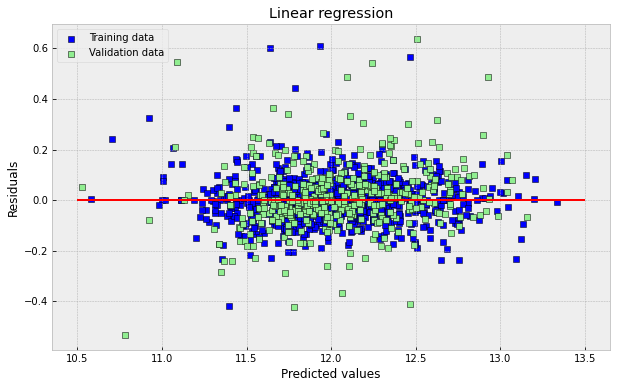

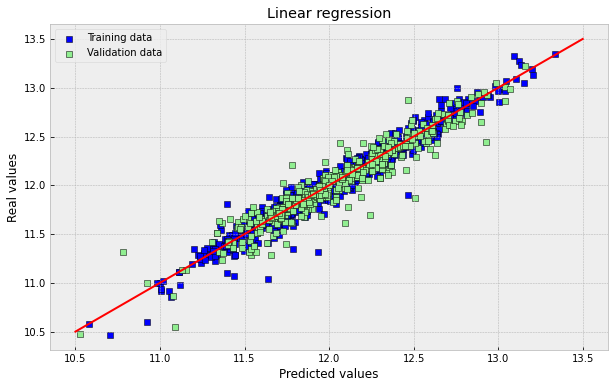

In [36]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())


# Plot residuals
plt.style.use('bmh')
plt.figure(figsize=(10,6))

plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", edgecolor= 'black', marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", edgecolor= 'black', marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.style.use('bmh')
plt.figure(figsize=(10,6))

plt.scatter(y_train_pred, y_train, c = "blue", edgecolor= 'black', marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", edgecolor= 'black', marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [37]:
y_train_pred

array([12.09908272, 11.84752302, 11.68674715, ..., 11.39935327,
       11.96826312, 12.27857074])

In [38]:
y_train

328    12.276
1026   12.029
843    11.857
994    12.729
1226   12.274
        ...  
765    12.484
837    11.513
1219   11.424
560    11.708
685    12.243
Name: SalePrice, Length: 1019, dtype: float64

# 2. Linear Regression with Ridge Regularization (L2 penalty)

In [39]:
# in L2 regularization, we penalize higher values of theta to reduce Overfitting

Best alpha : 30.0
Try again for more precision with alphas centered around 30.0
Best alpha : 24.0
Ridge RMSE on Training set : 0.11136257916455541
Ridge RMSE on Test set : 0.11136257916455541


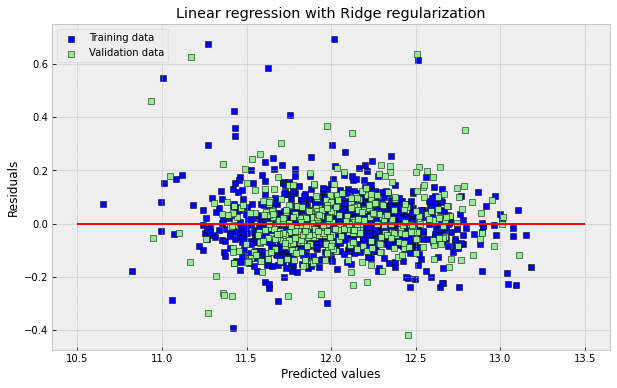

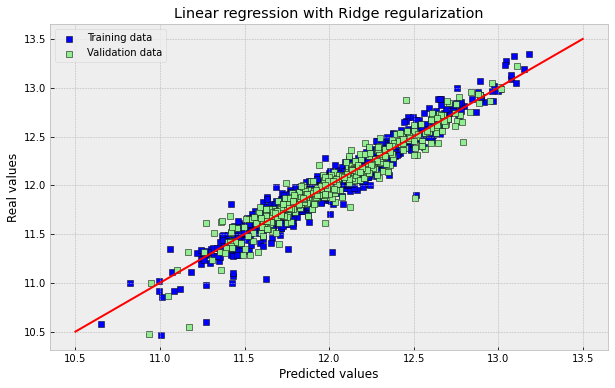

Ridge picked 315 features and eliminated the other 3 features


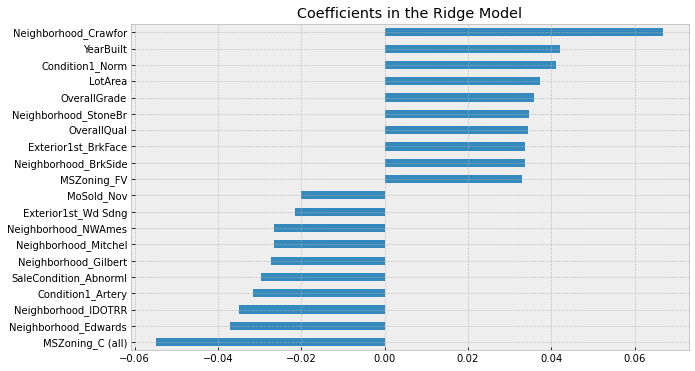

In [40]:
# 2. Ridge
# Alpha is the lambda parameter for tuning the regularization.

ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

# Plot residuals
plt.style.use('bmh')
plt.figure(figsize=(10,6))

plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", edgecolor='black', marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", edgecolor='black', marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.style.use('bmh')
plt.figure(figsize=(10,6))

plt.scatter(y_train_rdg, y_train, c = "blue", edgecolor='black', marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", edgecolor='black', marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
plt.style.use('bmh')
plt.figure(figsize=(10,6))

imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

# 3. Linear Regularization with LassoCV (L1 penalty)

Best alpha : 0.0006
Try again for more precision with alphas centered around 0.0006
Best alpha : 0.00057
Lasso RMSE on Training set : 0.1083216208799164
Lasso RMSE on Test set : 0.1083216208799164


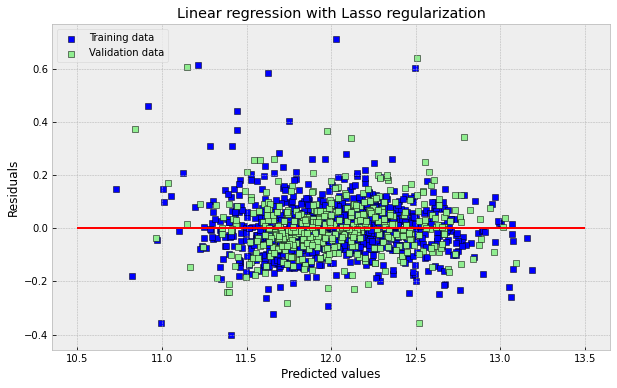

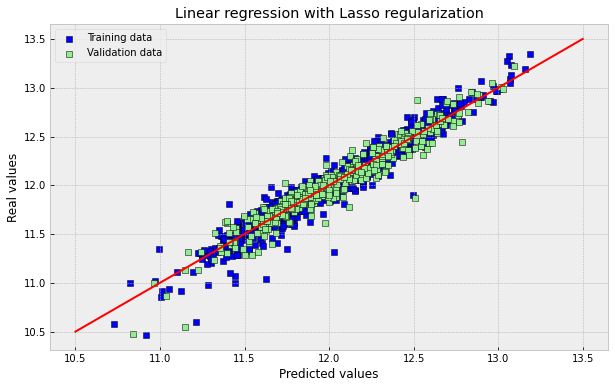

Lasso picked 111 features and eliminated the other 207 features


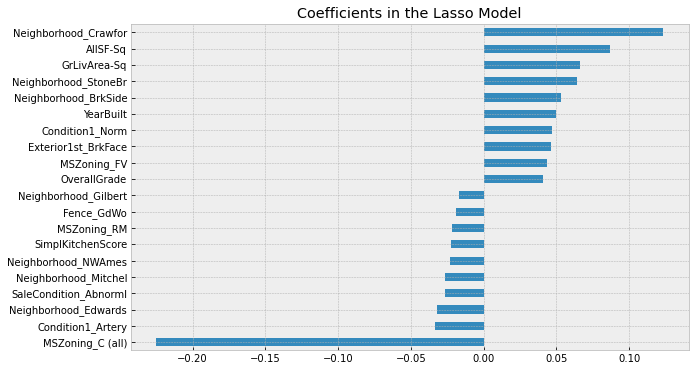

In [41]:
# 3. Lasso

lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.style.use('bmh')
plt.figure(figsize=(10,6))

plt.scatter(y_train_las, y_train_las - y_train, c = "blue", edgecolor='black', marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", edgecolor='black',  marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.style.use('bmh')
plt.figure(figsize=(10,6))

plt.scatter(y_train_las, y_train, c = "blue", edgecolor='black', marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", edgecolor='black', marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
plt.style.use('bmh')
plt.figure(figsize=(10,6))

imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

# 4. Linear Regularization with ElasticNet regularization (L1 and L2 penalty)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020653052199846478, tolerance: 0.01426910245430051
  model = cd_fast.enet_coordinate_descent_gram(


Best l1_ratio : 0.95
Best alpha : 0.0006
Try again for more precision with l1_ratio centered around 0.95
Best l1_ratio : 0.95
Best alpha : 0.0006
Now try again for more precision on alpha, with l1_ratio fixed at 0.95 and alpha centered around 0.0006
Best l1_ratio : 0.95
Best alpha : 0.0006
ElasticNet RMSE on Training set : 0.10832813202495253
ElasticNet RMSE on Test set : 0.10832813202495253


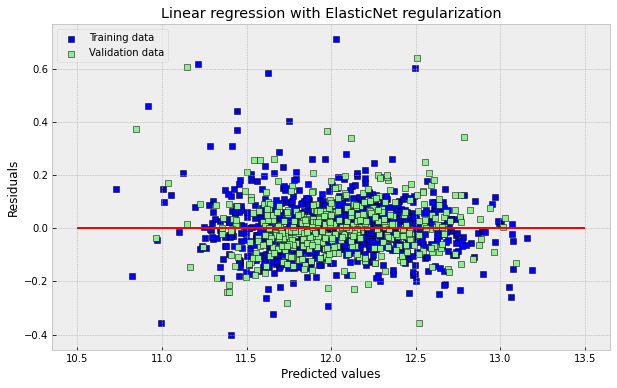

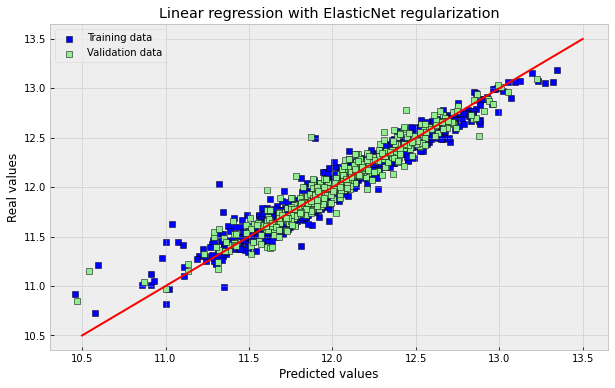

ElasticNet picked 112 features and eliminated the other 206 features


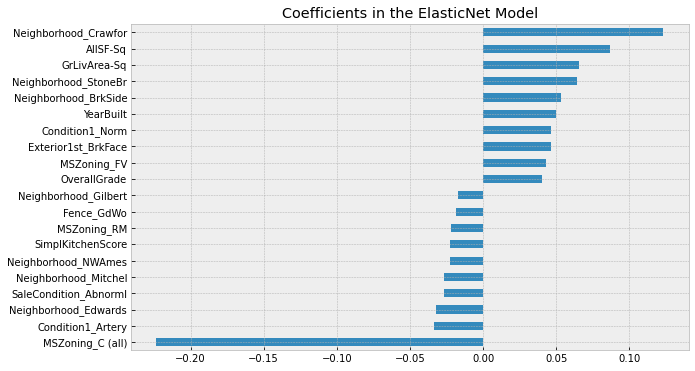

In [42]:
# 4. ElasticNet

elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

# Plot residuals
plt.style.use('bmh')
plt.figure(figsize=(10,6))

plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue",edgecolor= 'black',  marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen",edgecolor= 'black',  marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.style.use('bmh')
plt.figure(figsize=(10,6))

plt.scatter(y_train, y_train_ela, c = "blue", edgecolor= 'black', marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", edgecolor= 'black', marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
plt.style.use('bmh')
plt.figure(figsize=(10,6))
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()